In [1]:
import pandas as pd
import numpy as np
from path import Path
import torch.utils.data as data
from imageio import imread
import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline 
from torch.utils.data.sampler import SubsetRandomSampler

from PIL import *
import ast

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
df=pd.DataFrame()
azz={}

In [3]:
def plot_roc(y_test,y_score,n_classes):
    #y_test=N_elements
    #y_score=N_elements X N_classes
#     fpr = dict()
#     tpr = dict()
    y_test = label_binarize(y_test, classes=[0, 1, 2])
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    plt.figure()
    lw = 2
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    azz['fpr']=fpr['macro']
    azz['tpr']=tpr['macro']

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    print(fpr['macro'].shape,tpr['macro'].shape,roc_auc["macro"])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('LSTM X MLP  FOR  BCLL  DATASET')
    plt.legend(loc="lower right")
    plt.show()



In [4]:
import numpy as np

class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''
    # given query, key,value it finds the rightful weighted component of v to get the attention applied ouput
    #q,v,k- batch X length of sequence X features or encoding
    #attention sholuld be -batchX7X7
    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v, mask=None):
#         print(k.transpose(1,2).shape)

        attn = torch.bmm(q, k.transpose(1, 2)) 
#         print(attn.shape)
        attn = attn / self.temperature

        if mask is not None:
            attn = attn.masked_fill(mask, -np.inf)

        attn = self.softmax(attn)
        attn = self.dropout(attn)
#         print(str(attn.shape)+" "+str(v.shape))
        output = torch.bmm(attn, v)

        return output, attn
SDP=ScaledDotProductAttention(5)
Ss=SDP(torch.zeros(5,6,100),torch.zeros(5,6,100),torch.zeros(5,6,100))
# print(Ss[0].shape)
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k)
        self.w_ks = nn.Linear(d_model, n_head * d_k)
        self.w_vs = nn.Linear(d_model, n_head * d_v)
        nn.init.normal_(self.w_qs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_ks.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_k)))
        nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_model + d_v)))

        self.attention = ScaledDotProductAttention(temperature=np.power(d_k, 0.5))
        self.layer_norm = nn.LayerNorm(d_model)

        self.fc = nn.Linear(n_head * d_v, d_model)
        nn.init.xavier_normal_(self.fc.weight)

        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head

        sz_b, len_q, _ = q.size()
        sz_b, len_k, _ = k.size()
        sz_b, len_v, _ = v.size()
#         print(str(sz_b)+"die")

        residual = q

        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        q = q.permute(2, 0, 1, 3).contiguous().view(-1, len_q, d_k) # (n*b) x lq x dk
        k = k.permute(2, 0, 1, 3).contiguous().view(-1, len_k, d_k) # (n*b) x lk x dk
        v = v.permute(2, 0, 1, 3).contiguous().view(-1, len_v, d_v) # (n*b) x lv x dv
#         print("v-"+str(v.shape))
        if mask is not None:
            mask = mask.repeat(n_head, 1, 1) # (n*b) x .. x ..
        output, attn = self.attention(q, k, v, mask=mask)
#         print(q.shape,k.shape,v.shape)
        output = output.view(n_head, sz_b, len_q, d_v)
        output = output.permute(1, 2, 0, 3).contiguous().view(sz_b, len_q, -1) # b x lq x (n*dv)

        output = self.dropout(self.fc(output))
        output = self.layer_norm(output + residual)

        return output, attn
MHA=MultiHeadAttention(4,15,15,15)
op=MHA(torch.zeros(5,7,15),torch.zeros(5,7,15),torch.zeros(5,7,15))
# print(op[0].shape)
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Conv1d(d_in, d_hid, 1) # position-wise
        self.w_2 = nn.Conv1d(d_hid, d_in, 1) # position-wise
        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        output = x.transpose(1, 2)
#         print("FCC-"+str(output.shape))
#         print("FFC_out-"+str(self.w_1(output).shape))
        output = self.w_2(F.relu(self.w_1(output)))
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + residual)
        return output

    

In [5]:
class EncoderLayer(nn.Module):
    ''' Compose with two layers '''

    def __init__(self, d_model, d_inner, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner, dropout=dropout)

    def forward(self, enc_input, non_pad_mask=None, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, mask=slf_attn_mask)
#         print("ENC_o")
#         print(enc_output.shape)


        enc_output = self.pos_ffn(enc_output)


        return enc_output, enc_slf_attn
    
XX=EncoderLayer(15,10,4,10,10)

zz=XX(torch.zeros(5,7,15))
# print("ENc")
# print(zz[0].shape)
# print("start")
class Encoder(nn.Module):
    ''' A encoder model with self attention mechanism. '''

    def __init__(self,n_modality,d_model,n_head,d_k,d_v,dropout,n_layers,d_inner=500):
        #d_model - number of features in input 100 here
        #n_head - number of heads of multihaded attention
        #d_k=d_q=  number of features in query, key
        #d_v = number of features in value whose weighted(attentioned) sum we gonna take
        

        super().__init__()
        self.n_modality=n_modality
#         self.stn=nn.ModuleList([SpatialTransformer(3, (240,240), 8) for _ in range(n_ref)])
        
        self.layer_stack = nn.ModuleList([EncoderLayer(d_model, d_inner, n_head, d_k, d_v, dropout=dropout) 
                                          for _ in range(n_layers)])
        #self.em=nn.Linear(225,100)
        self.fc1=nn.Linear(d_model*n_modality,300)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(300,100)
        self.fc3=nn.Linear(100,3)
#         self.fc4=nn.Linear(50,3)
        self.bn1 = nn.BatchNorm1d(num_features=300)
        self.bn2 = nn.BatchNorm1d(num_features=100)
        self.softmax=nn.Softmax(1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, embeddings1,embeddings2 ):


        
        encodings_total=[embeddings1,embeddings2]

        enc_output=torch.stack(encodings_total,0)

        
        enc_output=enc_output.permute(1,0,2)
#         print("encoding_OUTPUT2-"+str(enc_output.shape))

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output,non_pad_mask=None,slf_attn_mask=None)
           
        
        final_input=enc_output.reshape(enc_output.shape[0],-1)

        final=self.relu(self.fc3(self.bn2(self.relu((self.fc2(self.bn1(self.relu(self.fc1(final_input)))))))))
        
        return(final)
     

In [6]:
e1=torch.zeros(4,100)
e2=torch.zeros(4,100)
e3=torch.stack([e1,e2],0)
e3.shape

torch.Size([2, 4, 100])

In [7]:
feature_set_MLP=pd.read_csv('BCLL_MLP_features_ankit.csv')
feature_set_LSTM=pd.read_csv('BCLL_LSTM_features_ankit.csv')
feature_set_MLP.head()

,gene_name,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99
0,hint1,125133.351562,357573.156250,0.000000,587084.000000,0.0,315726.906250,0.0,175430.843750,268782.625000,...,442658.781250,0.0,465458.937500,370437.156250,0.0,0.0,472186.937500,0.0,0.0,466427.312500
1,rabggta,20101.933594,62892.046875,0.000000,103993.031250,0.0,55333.929688,0.0,30097.763672,48279.539062,...,79100.062500,0.0,82092.179688,65288.472656,0.0,0.0,83334.328125,0.0,0.0,81504.468750
2,ywhae,6624.807129,14475.721680,0.000000,24332.548828,0.0,13422.669922,0.0,9587.588867,10549.949219,...,18221.716797,0.0,19292.927734,14790.755859,0.0,0.0,19355.056641,0.0,0.0,19177.373047
3,kat2b,4142.221680,8753.067383,0.000000,14703.916016,0.0,8161.906250,0.0,5902.970215,6346.573730,...,11016.152344,0.0,11690.555664,8958.273438,0.0,0.0,11691.131836,0.0,0.0,11626.661133
4,smad5,1322.737061,2288.863037,26.059177,3835.314453,0.0,2206.577148,0.0,1791.832397,1568.654663,...,2822.048828,0.0,3072.452148,2335.262207,0.0,0.0,3047.292969,0.0,0.0,3087.742920


In [8]:
feature_set_MLP.head()

,gene_name,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_90,tag_91,tag_92,tag_93,tag_94,tag_95,tag_96,tag_97,tag_98,tag_99
0,hint1,125133.351562,357573.156250,0.000000,587084.000000,0.0,315726.906250,0.0,175430.843750,268782.625000,...,442658.781250,0.0,465458.937500,370437.156250,0.0,0.0,472186.937500,0.0,0.0,466427.312500
1,rabggta,20101.933594,62892.046875,0.000000,103993.031250,0.0,55333.929688,0.0,30097.763672,48279.539062,...,79100.062500,0.0,82092.179688,65288.472656,0.0,0.0,83334.328125,0.0,0.0,81504.468750
2,ywhae,6624.807129,14475.721680,0.000000,24332.548828,0.0,13422.669922,0.0,9587.588867,10549.949219,...,18221.716797,0.0,19292.927734,14790.755859,0.0,0.0,19355.056641,0.0,0.0,19177.373047
3,kat2b,4142.221680,8753.067383,0.000000,14703.916016,0.0,8161.906250,0.0,5902.970215,6346.573730,...,11016.152344,0.0,11690.555664,8958.273438,0.0,0.0,11691.131836,0.0,0.0,11626.661133
4,smad5,1322.737061,2288.863037,26.059177,3835.314453,0.0,2206.577148,0.0,1791.832397,1568.654663,...,2822.048828,0.0,3072.452148,2335.262207,0.0,0.0,3047.292969,0.0,0.0,3087.742920


In [9]:
header_of_MLP=['tag_'+str(i) for i in range(feature_set_MLP.shape[1]-1)]
features_MLP=np.array(feature_set_MLP[header_of_MLP])
gene_MLP=feature_set_MLP['gene_name']
print(features_MLP.shape)
print(len(gene_MLP))

(4655, 100)
4655


In [10]:
dictionary_MLP={}
u=0
for gn in gene_MLP:
    dictionary_MLP[gn]=features_MLP[u]
    u=u+1

In [11]:
header_of_LSTM=['tag_'+str(i) for i in range(feature_set_LSTM.shape[1]-1)]
features_LSTM=np.array(feature_set_LSTM[header_of_LSTM])
gene_LSTM=feature_set_LSTM['gene_name']
print(features_LSTM.shape)
print(len(gene_LSTM))

(4275, 100)
4275


In [12]:
dictionary_LSTM={}
u=f=0
for gn in gene_LSTM:
    if gn in dictionary_LSTM.keys():
#         print(gn)
        f=f+1
    dictionary_LSTM[gn]=features_LSTM[u]
    u=u+1
print(f)

494


In [13]:
print(len(dictionary_LSTM.keys()))

3781


In [14]:
fil=open('../../Multi-modality/Model/BCLL/uni model/MLP/label0.txt','r')
tmp=list()
for line in fil:
	tmp.append(int(line))

label_BCLL=np.array(tmp)
print(label_BCLL.shape)

(4655,)


In [15]:
class Sequenceloader(data.Dataset):
    def __init__(self,GN,Feat,label):
        self.gene_names=GN
        self.features_mlp=Feat
        self.label=label
        self.coincdgene_name=[]
        self.coincidfeature_MLP=[]
        self.coincidfeature_LSTM=[]
        self.coincidlabel=[]
        for i in range(len(self.gene_names)):
            u=self.gene_names[i]
            if u in dictionary_LSTM.keys():
                
                if np.array(self.label[i])==0:
                    ch=60
                elif np.array(self.label[i])==1:
                    ch=8
                else:
                    ch=1
                    
                for jj in range(ch):
                    self.coincdgene_name.append(u)
                    self.coincidfeature_MLP.append(self.features_mlp[i])
                    self.coincidfeature_LSTM.append(dictionary_LSTM[u])
                    self.coincidlabel.append(self.label[i])
        
        
    
    def __len__(self):
#         print(len(self.dataset))
        return len(self.coincdgene_name)       

    def __getitem__(self, index):
         return np.array(self.coincidfeature_MLP[index]),np.array(self.coincidfeature_LSTM[index]),np.array(self.coincidlabel[index])
#         print(self.dataset['gen_name'][index])          
#         try:
           
#         except :
            
total_set=Sequenceloader(gene_MLP,features_MLP,label_BCLL)  
a=b=c=0
for x,y,z in total_set:
    if(z==0):
        a=a+1
    elif z==1:
        b=b+1
    else:
        c=c+1
print(a,b,c)
    

3360 3504 3781


In [16]:
batch_size = 4
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(total_set)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(total_set, batch_size=batch_size, 
                                           sampler=train_sampler,drop_last=True)
validation_loader = torch.utils.data.DataLoader(total_set, batch_size=batch_size,
                                                sampler=valid_sampler,drop_last=True)


In [17]:
for a,b,c in train_loader:
    print(a.shape,b.shape,c.shape)

torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4, 100]) torch.Size([4, 100]) torch.Size([4])
torch.Size([4,

In [18]:
device='cuda:7'
model_lstmXMLP=Encoder(2,100,4,300,300,True,4).to(device) #1)mlp 2lstm
uz=torch.rand(4, 100).to(device)
vz=torch.rand(4,100).to(device)
model_lstmXMLP(vz,uz).shape


torch.Size([4, 3])

In [19]:

model_lstmXMLP.load_state_dict(torch.load(Path('1ANKIT_BCLL COMBO_LSTMXMLP.pt')))
optim_params = [
    {'params': model_lstmXMLP.parameters(), 'lr': 0.0001}
]
optimizer = torch.optim.Adam(optim_params)
criterion = nn.CrossEntropyLoss()

In [20]:

y_score=[]
y_test=[]

total_imgs=0;
total_corrects=0
u=0
nb_classes=3
confusion_matrix = torch.zeros(nb_classes, nb_classes)
for i1,i2,label in validation_loader:


    output=model_lstmXMLP(i1.to(device).float(),i2.to(device).float())
    y_score.append(output)
    y_test.append(label)
    total_imgs=total_imgs+label.shape[0]
    print(output)
    z=torch.max(output,1)[1]==label.to(device)
    _, preds = torch.max(output, 1)
#         print(output.shape)

    num_corrects=torch.sum(z)
    total_corrects=total_corrects+num_corrects
    for t, p in zip(label.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1


    u=u+1


print(confusion_matrix)
print(total_corrects,total_imgs)

tensor([[0.0000, 1.0116, 4.6109],
        [0.0000, 3.6617, 6.7944],
        [4.9858, 0.0000, 0.0000],
        [0.0000, 3.6128, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 4.5882, 0.0000],
        [2.1443, 0.0000, 4.0123],
        [0.0000, 0.0000, 6.8327],
        [0.0000, 3.2347, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 1.7311, 5.6465],
        [0.0000, 3.0628, 0.0000],
        [0.0000, 0.1705, 5.9688],
        [1.1002, 0.0638, 3.7405]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 2.8721, 0.0000],
        [0.0000, 0.1919, 5.9101],
        [0.0000, 0.0000, 5.7585],
        [0.0000, 3.9213, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000e+00, 3.8325e+00, 0.0000e+00],
        [0.0000e+00, 3.2098e+00, 1.2793e+00],
        [0.0000e+00, 0.0000e+00, 3.5118e+00],
        [1.5271e-02, 3.6332e+00, 3.2657e-03]], device='cuda:7',
       grad_fn=<ThresholdBackward0

tensor([[0.0000, 3.6690, 0.0000],
        [0.0000, 0.0000, 2.9562],
        [0.0000, 0.0737, 5.9661],
        [0.0000, 3.7497, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 3.4810, 0.0000],
        [0.0000, 0.0000, 5.8748],
        [0.0000, 0.0000, 5.6624],
        [0.0000, 3.8771, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[5.7919, 0.0000, 0.0000],
        [0.0000, 3.9489, 0.3929],
        [0.0000, 5.5822, 2.5310],
        [0.0000, 0.0000, 5.2358]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[5.1268, 0.0000, 0.0000],
        [0.0000, 1.7339, 6.4888],
        [0.0000, 3.2620, 6.7918],
        [0.0000, 2.2794, 5.3148]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 1.8915, 5.0494],
        [4.6142, 0.0000, 0.0000],
        [0.0000, 3.0468, 5.5341],
        [0.0000, 2.8843, 6.5065]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 4.5314, 0.0000],
        [0.

tensor([[0.0000, 2.8582, 6.3721],
        [0.0000, 2.1883, 6.3040],
        [0.0000, 1.9859, 6.0513],
        [5.6875, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 2.5128, 7.5630],
        [5.6997, 0.0000, 0.0000],
        [0.0000, 4.3488, 0.0000],
        [7.0984, 0.3981, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.1060, 4.1734, 0.0000],
        [0.0000, 3.3491, 0.0000],
        [0.0927, 1.2272, 6.5470],
        [0.0000, 0.0000, 5.7184]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[4.9511, 0.0000, 0.0000],
        [0.0000, 1.7897, 8.1303],
        [0.0000, 1.9824, 4.4009],
        [0.0000, 4.1072, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 4.7648, 0.0000],
        [5.6443, 0.0000, 1.4494],
        [0.0000, 2.0543, 8.1099],
        [5.8912, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.0000, 0.0000],
        [1.

tensor([[0.0000, 3.8490, 0.0000],
        [0.1050, 3.3096, 0.0000],
        [0.0000, 4.4803, 0.0112],
        [0.0000, 0.0000, 5.3016]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.5061, 0.0000, 6.3123],
        [0.1167, 3.4923, 0.0000],
        [0.0000, 4.0062, 0.0000],
        [0.0000, 0.6724, 5.4326]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.6939, 3.8649, 2.7124],
        [0.0000, 0.0000, 6.1306],
        [0.0000, 5.0545, 0.0000],
        [3.5862, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 3.9070, 7.6783],
        [0.0335, 1.3055, 4.6238],
        [0.4232, 2.1924, 5.9374],
        [6.9620, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.0000, 4.1352],
        [0.0386, 0.0000, 6.0782],
        [0.2887, 3.3107, 0.0000],
        [0.0000, 4.9669, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 2.1137, 6.0342],
        [1.

tensor([[6.7297, 0.0000, 0.0000],
        [0.0000, 5.9667, 2.2131],
        [0.0000, 5.5270, 3.1453],
        [0.0000, 4.3075, 2.6707]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 1.4222, 6.5058],
        [0.0000, 4.1696, 0.0000],
        [0.0000, 3.0325, 5.7719],
        [5.4107, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 4.5984, 0.0000],
        [0.0000, 0.6459, 6.2665],
        [0.3760, 0.0000, 5.2979],
        [0.0000, 3.9658, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 1.0015, 8.3189],
        [0.0000, 4.2294, 0.0000],
        [0.0000, 2.7338, 4.2864],
        [4.8836, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.0000, 5.9509],
        [0.1103, 0.0000, 4.7745],
        [0.0000, 4.1168, 0.0000],
        [0.4249, 2.9245, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[6.0443, 0.0000, 0.5898],
        [5.

tensor([[0.0000, 1.7327, 4.0950],
        [0.0000, 5.7004, 1.6538],
        [6.4278, 0.0000, 0.0000],
        [0.0000, 5.3845, 2.7577]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.0000, 4.1740],
        [0.0000, 2.5083, 4.8736],
        [0.0000, 3.8153, 0.0000],
        [1.2383, 0.7686, 6.2460]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.0533, 2.3012],
        [1.3313, 2.0045, 5.9678],
        [6.4408, 0.0000, 0.0000],
        [0.0000, 4.7480, 4.9252]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[4.5242, 0.0000, 0.0000],
        [0.0000, 1.5064, 6.9553],
        [0.0000, 1.6426, 7.1462],
        [0.0000, 4.6944, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[3.7959, 0.0000, 0.4881],
        [0.0000, 1.9443, 6.8494],
        [0.0000, 5.1648, 0.0000],
        [5.7683, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[9.7880, 0.0000, 0.0000],
        [0.

tensor([[1.4984, 4.0817, 0.9549],
        [4.9916, 0.0000, 0.0000],
        [0.0000, 0.5110, 5.0715],
        [0.0000, 5.4477, 1.5478]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 1.3831, 7.8673],
        [4.6399, 0.0000, 0.0000],
        [0.0000, 3.4717, 5.8795],
        [0.0000, 2.5109, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[3.8742, 0.0000, 0.0000],
        [0.0000, 2.5725, 6.2196],
        [0.0000, 4.0301, 0.0000],
        [0.0000, 0.0000, 6.6347]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.0000, 6.0570],
        [0.6338, 4.1312, 0.5692],
        [4.4187, 0.0000, 0.0000],
        [0.0000, 4.8815, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[4.6247, 1.4361, 0.0000],
        [5.5434, 0.4811, 0.0000],
        [0.0000, 2.1553, 8.0642],
        [3.5162, 0.9556, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[7.0488, 1.6407, 0.0000],
        [4.

tensor([[6.0475, 0.0000, 0.0000],
        [0.0000, 4.8269, 0.0000],
        [0.0000, 1.8744, 8.3175],
        [5.9178, 0.0000, 0.2460]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.0000, 6.6211],
        [0.0000, 4.0616, 0.0000],
        [2.8805, 1.1100, 0.0000],
        [0.0000, 2.2089, 4.2731]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 4.2031, 0.0000],
        [0.0000, 0.5102, 5.2967],
        [1.1183, 0.0000, 6.1645],
        [0.0000, 3.5209, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[7.2866, 0.0000, 0.0000],
        [0.0000, 7.5765, 3.8377],
        [0.0000, 6.9213, 2.3847],
        [9.4004, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 3.9090, 0.0000],
        [0.0000, 2.2528, 4.6281],
        [4.7844, 0.0000, 0.0000],
        [0.0000, 1.5631, 8.0203]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 5.1842, 0.0000],
        [0.

tensor([[5.8589, 0.0000, 0.0000],
        [7.0160, 2.1499, 1.1655],
        [3.9808, 0.0000, 0.0000],
        [0.0000, 7.1900, 3.9304]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 2.0343, 5.9657],
        [0.0000, 0.0000, 3.5640],
        [0.6005, 0.0000, 5.2243],
        [0.0000, 3.5763, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 1.6063, 6.5360],
        [0.0000, 3.1744, 7.0280],
        [5.7634, 0.0000, 0.0000],
        [0.0000, 2.5148, 5.0581]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 3.5948, 7.4410],
        [0.0000, 1.9214, 7.1921],
        [8.1511, 0.0000, 0.0000],
        [4.6057, 0.1684, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[6.5471, 0.0000, 0.0301],
        [5.3976, 0.5809, 1.6400],
        [5.5215, 0.0000, 0.0000],
        [0.0000, 8.0519, 2.9305]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[6.5098, 0.0000, 1.1868],
        [3.

tensor([[5.3092, 0.0000, 0.0000],
        [5.3686, 0.6324, 0.0000],
        [0.0000, 1.8089, 8.2198],
        [0.0000, 4.1134, 0.4276]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[4.0522, 0.0000, 0.0000],
        [0.0000, 0.9339, 6.9594],
        [0.0000, 3.9206, 0.0000],
        [0.0000, 3.5570, 5.1823]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[1.7412, 0.4671, 4.5367],
        [3.0139, 0.0000, 0.0000],
        [0.0000, 3.0010, 8.3396],
        [0.0000, 2.7050, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.2587, 1.4270, 4.9510],
        [0.0000, 1.4530, 7.6158],
        [4.4589, 0.0000, 0.0000],
        [0.0000, 4.3823, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 0.3106, 6.2907],
        [0.2524, 3.7377, 0.0000],
        [5.1953, 0.0000, 0.0000],
        [0.0000, 4.5290, 0.9858]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[3.8065, 0.0000, 0.0000],
        [0.

tensor([[0.0000, 2.4612, 3.0313],
        [0.0000, 2.4612, 3.0313],
        [1.2512, 1.6285, 1.8006],
        [0.0000, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[6.4029, 0.0000, 0.0000],
        [0.0000, 2.4695, 6.8349],
        [0.0000, 4.1687, 7.8011],
        [8.4594, 0.0000, 0.0000]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[3.7350, 0.0000, 0.0000],
        [1.6377, 4.3532, 0.1537],
        [0.0000, 5.8594, 1.7916],
        [0.0000, 1.1274, 4.5054]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[5.8518, 0.0000, 0.0000],
        [5.5367, 0.0000, 0.0340],
        [0.0000, 4.8979, 0.0000],
        [0.0000, 1.9770, 7.5492]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[0.0000, 5.9315, 0.7470],
        [0.0000, 0.0000, 5.0577],
        [4.9919, 0.0000, 0.0000],
        [0.0000, 4.7677, 2.1337]], device='cuda:7',
       grad_fn=<ThresholdBackward0>)
tensor([[678.,   4.,   8.],
        [ 16., 64

In [21]:
print(torch.cat(y_test,0).shape)
print(torch.cat(y_score,0).shape)

torch.Size([2128])
torch.Size([2128, 3])


TypeError: list indices must be integers or slices, not str

<Figure size 432x288 with 0 Axes>

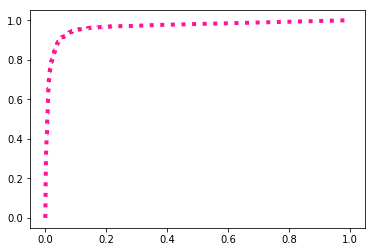

In [22]:
plot_roc(torch.cat(y_test,0).numpy(),torch.cat(y_score,0).cpu().detach().numpy(),3)

In [25]:

dataset = pd.DataFrame({'fpr':azz['tpr'],'tpr':azz['fpr']})

In [26]:
dataset.to_csv('bcll_lstmXmlp_roc.csv')